# 💡 SUPPLY / DEMAND INDICATOR

## 📌 Overview
This notebook link the two previously processed - supply (JOCAS) and demand (STMT) for the year 2020 - dataset in order to build a simple indicator of tension at the commune level (most granular possible). 

In [1]:
# ---------------------------------------------------
# Import necessary libraries
# ---------------------------------------------------

# System libraries
import importlib, subprocess, sys, os, re
from pathlib import Path

# If already installed --> import, if not --> install packages
packages = {
    'pandas': 'pd',
    'numpy': 'np',
    'matplotlib.pyplot': 'plt',
    'unidecode': 'unidecode',
    'geopandas': 'gpd',
    'contextily': 'ctx',
    'matplotlib.colors': 'mcolors',
    'matplotlib.patches': 'mpatches'
}
for mod, alias in packages.items():
    try:
        globals()[alias] = importlib.import_module(mod)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", mod.split('.')[0]])
        globals()[alias] = importlib.import_module(mod)
        

In [6]:
# ---------------------------------------------------
# Define the project's root directory
# ---------------------------------------------------
# Get the current working directory and assume that the project root is one level above.
project_root = Path().resolve().parent

# ---------------------------------------------------
# Construct file paths for each dataset
# ---------------------------------------------------
stmt_file = project_root / "data" / "2- Formatted Data" / "stmt_demand_processed.csv"
jocas_file = project_root / "data" / "2- Formatted Data" / "jocas_offers_processed.csv"
shapefile = project_root / "data" / "shapefiles" / "Zones d'Emploi" / "ze2020_2022.shp"
comm_to_ze_file = project_root / "data" / "linking tables" / "Communes_to_ZE_2022.xlsx"
rome_fap_file = project_root / "data" / "linking tables" / "Rome_to_Fap_processed.csv"
departement_file = project_root / "data" / "linking tables" / "departements-francais.xlsx"

# ---------------------------------------------------
# Import data from files
# ---------------------------------------------------
stmt = pd.read_csv(stmt_file)
jocas = pd.read_csv(jocas_file)
ze_shp = gpd.read_file(shapefile)
comm_to_ze = pd.read_excel(comm_to_ze_file, sheet_name=1, skiprows=5)
rome_fap = pd.read_csv(rome_fap_file)
departement = pd.read_excel(departement_file, skiprows=2)

# ---------------------------------------------------
# Specify the output file path
# ---------------------------------------------------
output_path = project_root / "data" / "3- Final Data" / "ratio_supply_demand.csv"


## 1- WORKFLOW

In [30]:
# ---------------------------------------------------
# MERGE JOB OFFERS AND DEMAND DATA
# ---------------------------------------------------
df = jocas.merge(stmt, on=["commune", "fap87", "month"], how="outer")

# ---------------------------------------------------
# PROCESS COMMUNES TO ZONE-D'EMPLOI DATA
# ---------------------------------------------------
# Rename columns for clarity
comm_to_ze.rename(columns={"LIBGEO": "commune", "LIBZE2020": "zone_emploi"}, inplace=True)

# Standardize commune names: remove accents, convert to lowercase, replace hyphens/apostrophes, and normalize "St." to "saint"
def standardize_commune(name):
    if pd.isna(name):
        return None
    name = unidecode.unidecode(name.lower().strip())
    name = re.sub(r"[-'’]", " ", name)
    name = re.sub(r"\bst[ .]", "saint ", name)
    return name

comm_to_ze["commune"] = comm_to_ze["commune"].apply(standardize_commune)

# Merge the standardized communes data
df = df.merge(comm_to_ze, on="commune", how="left")

# ---------------------------------------------------
# AGGREGATE DATA BY ZONE D'EMPLOI, FAP, AND MONTH
# ---------------------------------------------------
df = df.groupby(["zone_emploi", "fap87", "month"], as_index=False).agg(
    job_offers=("job_offers_fap87", "sum"),
    jobseekers_a=("jobseeker_a", "sum"),
    jobseekers_abc=("jobseeker_abc", "sum"),
    departement=("DEP", "first"),
    region=("REG", "first")
)

# ---------------------------------------------------
# MAP DEPARTEMENT AND REGION NAMES
# ---------------------------------------------------
# Ensure that the initial dep/reg code are strings
df["departement"] = df["departement"].astype(str)
df["region"] = df["region"].astype(str)

# Ensure department numbers are two digits
departement["Département\nNuméro"] = departement["Département\nNuméro"].astype(str).str.zfill(2)
dept_mapping = departement.set_index("Département\nNuméro")["Département\nNom"].to_dict()
df["departement"] = df["departement"].map(dept_mapping)

reg_mapping = departement.set_index("Département\nNom")["Région"].to_dict()
df["region"] = df["departement"].map(reg_mapping)

# ---------------------------------------------------
# PRE-PROCESS DATA AND HANDLE ZEROS
# ---------------------------------------------------
df["job_offers"] = pd.to_numeric(df["job_offers"], errors="coerce").fillna(0).astype(int)
df["jobseekers_a"] = pd.to_numeric(df["jobseekers_a"], errors="coerce").fillna(0).astype(int)
df["jobseekers_abc"] = pd.to_numeric(df["jobseekers_abc"], errors="coerce").fillna(0).astype(int)

# Merge fap87 family information
df = df.merge(rome_fap[["fap87", "famille_pro87"]], on="fap87", how="left")

# Adjust zeros to avoid division issues
df["job_offers"] = np.where(df["job_offers"] == 0, 0, df["job_offers"])
df["jobseekers_a"] = np.where(df["jobseekers_a"] == 0, 1, df["jobseekers_a"])
df["jobseekers_abc"] = np.where(df["jobseekers_abc"] == 0, 1, df["jobseekers_abc"])

# ---------------------------------------------------
# COMPUTE RATIOS AND STANDARDIZED Z-SCORES
# ---------------------------------------------------
df["ratio_a"] = df["job_offers"] / df["jobseekers_a"]
df["ratio_abc"] = df["job_offers"] / df["jobseekers_abc"]

mean_tightness_a = df["ratio_a"].mean()
std_tightness_a = df["ratio_a"].std()
mean_tightness_abc = df["ratio_abc"].mean()
std_tightness_abc = df["ratio_abc"].std()

df["ratio_zscore_a"] = (df["ratio_a"] - mean_tightness_a) / std_tightness_a
df["ratio_zscore_abc"] = (df["ratio_abc"] - mean_tightness_abc) / std_tightness_abc

# ---------------------------------------------------
# COMPUTE YEARLY MEANS AND QUINTILE SCORES
# ---------------------------------------------------
# Calculate yearly mean ratios and z-scores per zone d'emploi and fap87
df["ymean_ratio_a"] = df.groupby(["zone_emploi", "fap87"])["ratio_a"].transform("mean")
df["ymean_ratio_abc"] = df.groupby(["zone_emploi", "fap87"])["ratio_abc"].transform("mean")
df["ymean_ratio_zscore_a"] = df.groupby(["zone_emploi", "fap87"])["ratio_zscore_a"].transform("mean")
df["ymean_ratio_zscore_abc"] = df.groupby(["zone_emploi", "fap87"])["ratio_zscore_abc"].transform("mean")

# Aggregate unique zone/fap combinations for scoring
df_temp = df.groupby(["zone_emploi", "fap87"], as_index=False).agg(
    ymean_ratio_zscore_a=("ymean_ratio_zscore_a", "first"),
    ymean_ratio_zscore_abc=("ymean_ratio_zscore_abc", "first")
)

# Compute quintile scores for the mean z-scores
df_temp["lt_score_a"] = pd.qcut(df_temp["ymean_ratio_zscore_a"], q=5, labels=[1, 2, 3, 4, 5]).astype(int)
df_temp["lt_score_abc"] = pd.qcut(df_temp["ymean_ratio_zscore_abc"], q=5, labels=[1, 2, 3, 4, 5]).astype(int)

# Merge the scores back into the main dataframe
df = df.merge(df_temp[["zone_emploi", "fap87", "lt_score_a", "lt_score_abc"]], on=["zone_emploi", "fap87"], how="left")

# Drop duplicated lines (why are they duplicated? I don't know)
df.drop_duplicates(subset=["zone_emploi", "famille_pro87", "month"], inplace=True)

# ---------------------------------------------------
# MERGE WITH ZONE-D'EMPLOI SHAPEFILE
# ---------------------------------------------------
df = df.merge(ze_shp, left_on="zone_emploi", right_on="libze2020", how="left")


## 2- CHECKS

Only 4 zones urbaines are not covered by our data, however it is important to note that data for each zone urbaine is only linked to communes with more than 5000 habitants.

In [23]:
# ----------------------------------------
# NUMBER OF ZONE EMPLOI IN THE SHAPEFILE
# ----------------------------------------
ze_tot = ze_shp["libze2020"].nunique()
print(f"Number of zone d'emplois in France: {ze_tot}")

# ----------------------------------------
# NUMBER OF ZONE EMPLOI IN OUR DATA
# ----------------------------------------
ze_df = df["libze2020"].nunique()
print(f"Number of zone d'emplois in our Data: {ze_df}")

Number of zone d'emplois in France: 305
Number of zone d'emplois in our Data: 301


### How is constructed the labour tightness score?

- First : computed the ratio joboffer/jobseeker for each zone emploi-fap87-month --> if the ratio is 1 there is equivalent number of job and offer; if it is below one, there is more demand than offer which means the market is "slack"; if it is above 1, there is more offer than demand, which means that the market is tighter
- We standardize the ratio (here taking the mean and standard deviation of ratios for all the year 2020 and across all fap --> the best we can do with our data, but would have been better to take the mean and sd of previous years like (2014-2018)
- We want to compute a score, but only for the full year 2020 (so taking the mean ratios of all months for each of zone emploi-fap), as to avoid complex visualisation and missings. We then create a score from 1 to 5 using the quantile distribution of the "yearly mean standardized ratio"
- In order to define each of those categories we look back at the row ratio (the only one that has a meaning), we look at the row ratio's range for each of the 5 categories

We see that for both score_a and score_abc, categories 1, 2 and 3 are below 1 meaning they show some degressive slack conditions, and category 4 and 5 are above 1 meaning the market is tighter.

In [15]:
# ----------------------------------------------------------------------
# CHECKING RANGE OF ROW RATIO FOR EACH CATEGORY OF SCORE FOR CATEGORY A
# ----------------------------------------------------------------------
for score in [1,2,3,4,5]:
    max_ratio = df[df["lt_score_a"]==score]["ymean_ratio_a"].min()
    max_ratio = round(max_ratio, 2)
    print(f"The maximum ratio (A) for score category {score} is: {max_ratio}")
print("\n")

# ----------------------------------------------------------------------
# CHECKING RANGE OF ROW RATIO FOR EACH CATEGORY OF SCORE FOR CATEGORY ABC
# ----------------------------------------------------------------------
for score in [1,2,3,4,5]:
    max_ratio = df[df["lt_score_abc"]==score]["ymean_ratio_abc"].min()
    max_ratio = round(max_ratio, 2)
    print(f"The maximum ratio (ABC) for score category {score} is: {max_ratio}")

The maximum ratio (A) for score category 1 is: 0.0
The maximum ratio (A) for score category 2 is: 0.12
The maximum ratio (A) for score category 3 is: 0.36
The maximum ratio (A) for score category 4 is: 1.06
The maximum ratio (A) for score category 5 is: 3.01


The maximum ratio (ABC) for score category 1 is: 0.0
The maximum ratio (ABC) for score category 2 is: 0.09
The maximum ratio (ABC) for score category 3 is: 0.28
The maximum ratio (ABC) for score category 4 is: 1.0
The maximum ratio (ABC) for score category 5 is: 3.0


Our computed score gives 5 categories with balanced distribution 

/Users/alfonso/anaconda3/lib/python3.11/site-packages/contextily/tile.py:645: UserWarning: The inferred zoom level of 23 is not valid for the current tile provider (valid zooms: 0 - 20).
  warnings.warn(msg)


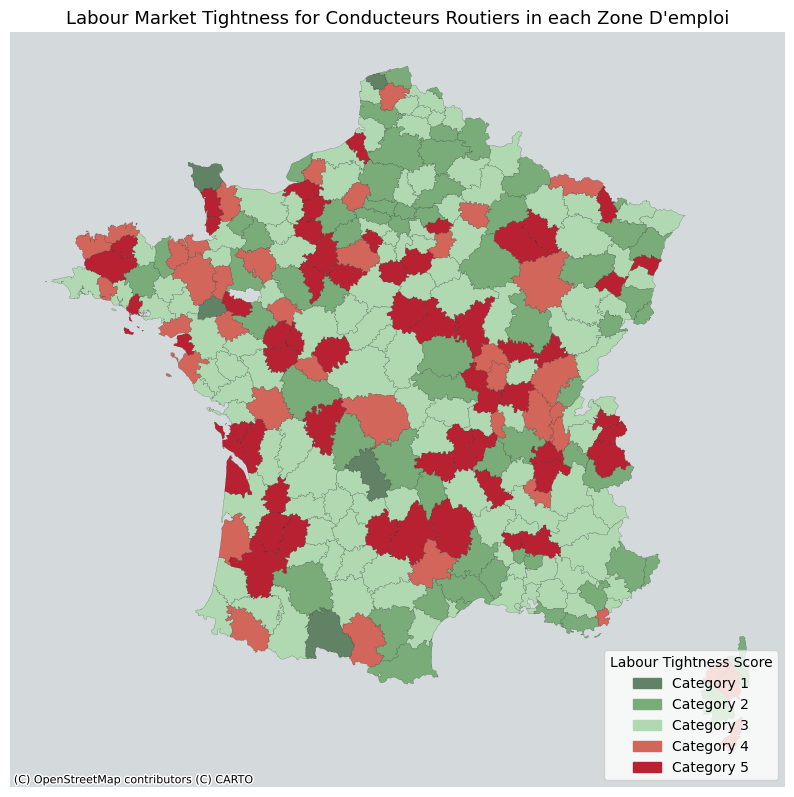

In [22]:
# ---------------------------------------------------
# Filter dataset and select relevant columns
# ---------------------------------------------------
fap_filter = df["famille_pro87"] == 'Bouchers, charcutiers, boulangers'
df_map = df[fap_filter].drop_duplicates(subset=["zone_emploi", "fap87"])[["lt_score_abc", "geometry"]]

# ---------------------------------------------------
# Convert to GeoDataFrame with proper CRS and filter out missing geometries
# ---------------------------------------------------
df_map = gpd.GeoDataFrame(df_map, geometry="geometry", crs="EPSG:4326")

# ---------------------------------------------------
# Filter geometries within mainland France bounding box
# ---------------------------------------------------
xmin, xmax, ymin, ymax = -5, 10, 41, 52
bounds = df_map.geometry.bounds
df_map = df_map[
    (bounds.minx >= xmin) & (bounds.maxx <= xmax) &
    (bounds.miny >= ymin) & (bounds.maxy <= ymax)
]

# ---------------------------------------------------
# Define a fixed colormap and normalization for lt_score_abc
# ---------------------------------------------------
colors = ["#618264", "#79AC78", "#B0D9B1", "#D2665A", "#B82132"]
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm([1, 2, 3, 4, 5, 6], cmap.N)

# ---------------------------------------------------
# Create the plot
# ---------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 12))
df_map.plot(column="lt_score_abc", cmap=cmap, norm=norm, linewidth=0.1,
            edgecolor="black", legend=False, ax=ax)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

legend_patches = [mpatches.Patch(color=colors[i-1], label=f"Category {i}") for i in range(1, 6)]
ax.legend(handles=legend_patches, title="Labour Tightness Score", loc="lower right", frameon=True)

ax.set_title("Labour Market Tightness for Conducteurs Routiers in each Zone D'emploi", fontsize=13)
ax.set_axis_off()
plt.show()

## 3- EXPORT FILE

In [32]:
# Keep columns of interest
columns_to_keep = ["zone_emploi", "famille_pro87", "month", "job_offers", "jobseekers_a", 
                   "jobseekers_abc", "ratio_a", "ratio_abc", "ratio_zscore_a", "ratio_zscore_abc",
                   "ymean_ratio_a", "ymean_ratio_abc", "ymean_ratio_zscore_a", "ymean_ratio_zscore_abc", 
                   "lt_score_a", "lt_score_abc", "departement", "region"]
df = df[columns_to_keep]

# EXPORT DATASET 
df.to_csv(output_path, index=False)

In [33]:
# Print final dataset
df.head(5)

,zone_emploi,famille_pro87,month,job_offers,jobseekers_a,jobseekers_abc,ratio_a,ratio_abc,ratio_zscore_a,ratio_zscore_abc,ymean_ratio_a,ymean_ratio_abc,ymean_ratio_zscore_a,ymean_ratio_zscore_abc,lt_score_a,lt_score_abc,departement,region
0,Abbeville,"Agriculteurs, éleveurs, sylviculteurs, bûcherons",April,3,10,10,0.3,0.3,-0.294553,-0.284454,0.091667,0.083333,-0.319152,-0.310019,1,1,Somme,Hauts-de-France
1,Abbeville,"Agriculteurs, éleveurs, sylviculteurs, bûcherons",August,2,10,10,0.2,0.2,-0.306361,-0.296253,0.091667,0.083333,-0.319152,-0.310019,1,1,Somme,Hauts-de-France
2,Abbeville,"Agriculteurs, éleveurs, sylviculteurs, bûcherons",December,0,10,10,0.0,0.0,-0.329975,-0.319852,0.091667,0.083333,-0.319152,-0.310019,1,1,Somme,Hauts-de-France
3,Abbeville,"Agriculteurs, éleveurs, sylviculteurs, bûcherons",February,0,20,20,0.0,0.0,-0.329975,-0.319852,0.091667,0.083333,-0.319152,-0.310019,1,1,Somme,Hauts-de-France
4,Abbeville,"Agriculteurs, éleveurs, sylviculteurs, bûcherons",January,2,10,20,0.2,0.1,-0.306361,-0.308052,0.091667,0.083333,-0.319152,-0.310019,1,1,Somme,Hauts-de-France
